In [7]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain[google-genai]

In [8]:
from pprint import pprint

from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mamals", name = "Model")]
messages.append(HumanMessage(content = f"Yes you are right", name = "Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mamals
================================ Human Message =================================
Name: Lance

Yes you are right
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [9]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI

#from langchain.chat_models import init_chat_model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.0) 

#llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [12]:
result = llm.invoke(messages)

In [13]:
result

AIMessage(content='Okay! When it comes to Orca (Killer Whale) sightings in the US, the **Pacific Northwest** is definitely the prime location. Here\'s a breakdown of some of the best places, considering different factors:\n\n**1. San Juan Islands, Washington State:**\n\n*   **Why it\'s great:** This is arguably the *most* famous and reliable place to see Orcas in the US. The Southern Resident Killer Whales (SRKW) are frequently found here, especially during the summer months (May-September) when they follow salmon runs.\n*   **How to see them:**\n    *   **Whale Watching Tours:** Numerous reputable tour operators depart from Friday Harbor, San Juan Island, and other nearby locations. They use hydrophones to listen for Orca calls and follow responsible viewing guidelines.\n    *   **Land-Based Viewing:** Lime Kiln Point State Park (nicknamed "Whale Watch Park") on San Juan Island is a fantastic spot for land-based viewing. You\'ll need binoculars and patience, but it\'s free (aside from

In [14]:
def multiply(a: int, b:int) -> int:
    """
        Multiply a and b
        Args:
            a: first int
            b: second int
    
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])


In [15]:
tool_call = llm_with_tools.invoke([
    HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")    
])

In [16]:
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9f5aa34e-2c6a-4681-92c4-8d085fc253b1-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '8e6d1d17-f966-4629-b1bc-ee454a6f4f08', 'type': 'tool_call'}], usage_metadata={'input_tokens': 35, 'output_tokens': 5, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}})

In [17]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'b': 3.0, 'a': 2.0},
  'id': '8e6d1d17-f966-4629-b1bc-ee454a6f4f08',
  'type': 'tool_call'}]

In [20]:
from typing import TypedDict
from typing import Annotated

from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    

In [19]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='ba50ace4-65f8-4a30-a0cc-3f9ce0067679'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='f48c3112-5000-472f-85f2-6e927a4d7c7a'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='fa6fd0a8-1edf-4049-a54b-b76cc5c67218')]

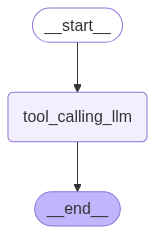

In [25]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def tool_calling_llm(state: MessagesState):
    return {"messages": llm_with_tools.invoke(state["messages"])}


builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [26]:
messages = graph.invoke({
    "messages": HumanMessage(content = "Hello")
})

messages

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='45683548-8068-4078-a046-b97edcf28149'),
  AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6a5b235a-694f-4e72-b0ac-35ddd4dc1933-0', usage_metadata={'input_tokens': 28, 'output_tokens': 10, 'total_tokens': 38, 'input_token_details': {'cache_read': 0}})]}

In [27]:
messages = graph.invoke({
    "messages": HumanMessage(content = "What is 2 multiply 3")
})

messages

{'messages': [HumanMessage(content='What is 2 multiply 3', additional_kwargs={}, response_metadata={}, id='de44300c-355a-483c-a599-92995d1bfa08'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 3.0, "a": 2.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--1b878dcf-c0d0-44ea-aa40-798e8d734029-0', tool_calls=[{'name': 'multiply', 'args': {'b': 3.0, 'a': 2.0}, 'id': '029dfbf4-67a1-45e4-8fc1-6bce12a8240e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 34, 'output_tokens': 5, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}})]}

In [28]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiply 3
================================== Ai Message ==================================
Tool Calls:
  multiply (029dfbf4-67a1-45e4-8fc1-6bce12a8240e)
 Call ID: 029dfbf4-67a1-45e4-8fc1-6bce12a8240e
  Args:
    b: 3.0
    a: 2.0
